In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=160, facecolor='w', edgecolor='k')
from tqdm.notebook import tqdm
from collections import Counter
import re
from ast import literal_eval

# conclusions:

1. each phase covers exactly 4 days
2. the length of a day is 0.0000547
3. phase i overlaps with phase i-1 over 3 days
4. a session could be defined as every span of item clicks where the maximum distance between two consecutive clicks is an hour
5. 97% of all click diffs have less than a 1 hour offset
6. all qtime test queries happen after the last test click 


In [3]:
def filename_from_args(dataset_path, domain, traintest, phase, filetype, extension):
    """gets folder structure filename from arguments

    Arguments:
        dataset_path -- root path
        domain {[type]} -- [description]
        traintest {[type]} -- [description]
        phase {[type]} -- [description]
        filetype {[type]} -- [description]

    Raises:
        Exception: [description]

    Returns:
        [type] -- [description]
    """
    folder = Path(f"{dataset_path}/{domain}/underexpose_{traintest}")

    if filetype in ["click", "qtime"]:
        filename = f"underexpose_{traintest}_{filetype}-{phase}.{extension}"
    elif filetype in ["user", "item"]:
        filename = f"underexpose_{filetype}_feat.{extension}"
    else:
        raise Exception("filetype not recognized")
        
    return folder, filename

def get_raw_dataset(domain="international", traintest="train", phase="0", filetype="click"):
    """gets dataset associated with arguments and does some cleaning

    Keyword Arguments:
        domain {str} -- "international" or "china" (default: {"international"})
        traintest {str} -- "train" or "test" (default: {"train"})
        phase {str} -- number between 0 and 6. (default: {"0"})
        filetype {str} -- one of "click", "item", "user", "qtime" (default: {"click"})
        
    if filetype is click, user or qtime, returns cleaned dataframe
    if filetype is item, returns the item_ids, text_vecs, and img_vecs
    """

    folder, filename= filename_from_args("dataset", domain, traintest, phase, filetype, "csv")

    if filetype == "item":
        header = ["item_id","text_vec","img_vec"]
        with open(folder/filename) as handle:
            lines = handle.readlines()
            item_ids = np.zeros(len(lines))
            text_vec = np.zeros((len(lines), 128))
            img_vec = np.zeros((len(lines), 128))
            for i, line in tqdm(list(enumerate(lines))):
                line = literal_eval(line)[1]
                item_ids[i] = line[0]
                text_vec[i] = line[1]
                img_vec[i] = line[2]
        return item_ids, text_vec, img_vec
    
    if filetype == "click":
        header = ["user_id","item_id","time"]
        dataframe = pd.read_csv(folder/filename, sep=",", names=header)
    elif filetype == "qtime":
        header = ["user_id", "time"]
        dataframe = pd.read_csv(folder/filename, sep=",", names=header)
    elif filetype == "user":
        header = ["user_id","user_age_level","user_gender","user_city_level"]
        dataframe = pd.read_csv(folder/filename, sep=",", names=header)

        average_city_level = dataframe["user_city_level"].mean()
        average_city_level_map = {k:k for k in range(20)}
        average_city_level_map[None] = average_city_level
        dataframe["user_city_level"] = dataframe["user_city_level"].map(average_city_level_map)
        
        average_age = dataframe["user_age_level"].mean()
        average_age_map = {k:k for k in range(20)}
        average_age_map[None] = average_age
        dataframe["user_age_level"] = dataframe["user_age_level"].map(average_age_map)
        
        dataframe["user_gender"] = dataframe["user_gender"].map({"M": 1, "F":-1, None:0})

    return dataframe

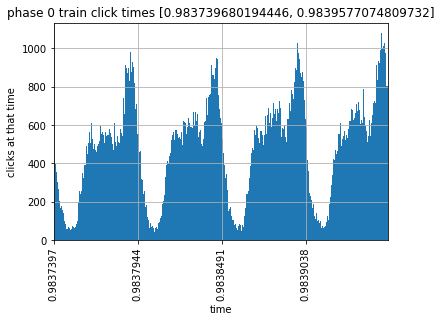

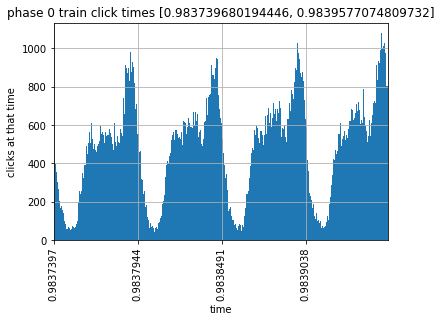

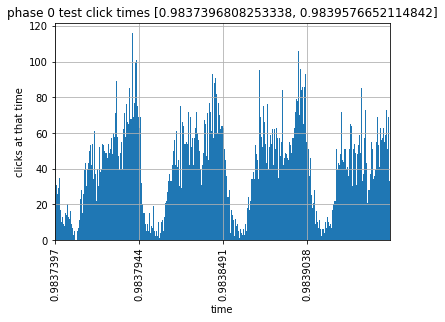

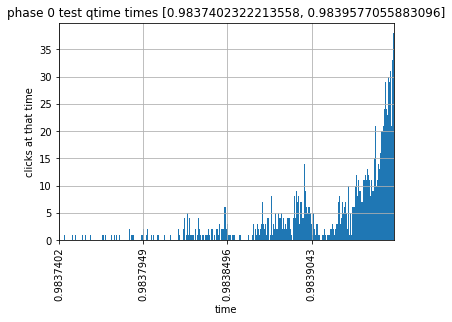

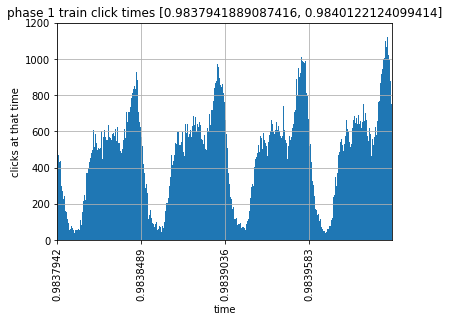

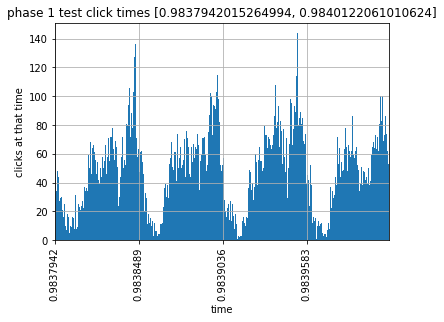

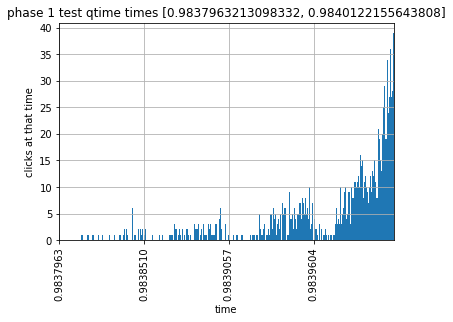

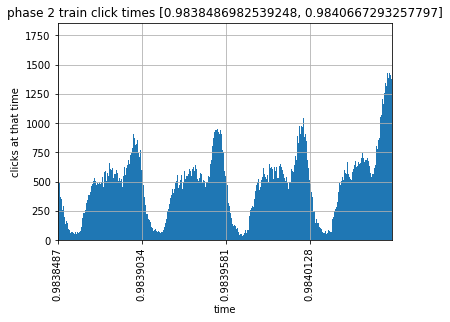

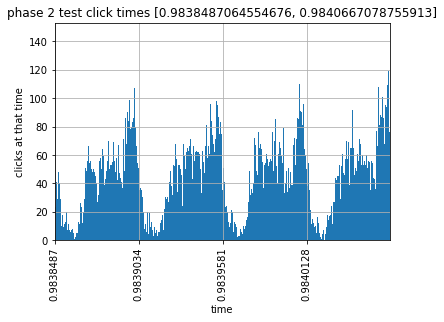

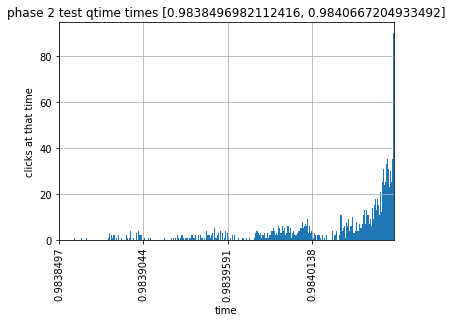

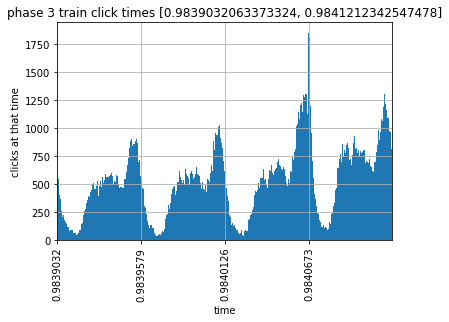

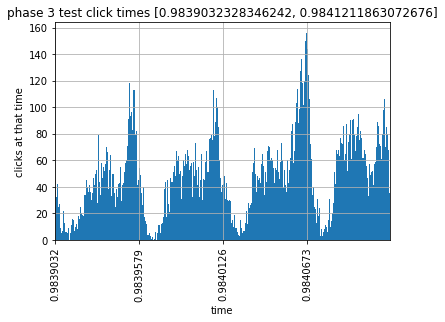

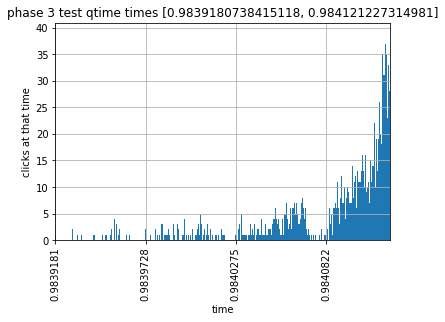

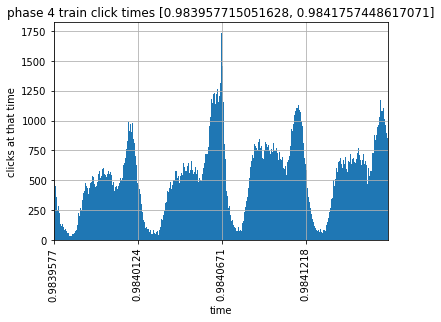

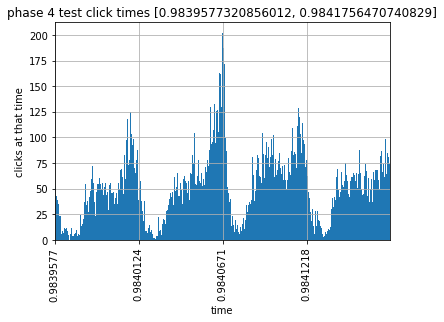

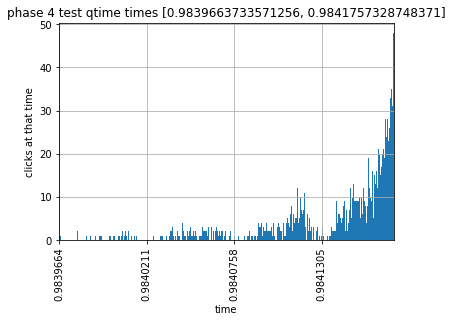

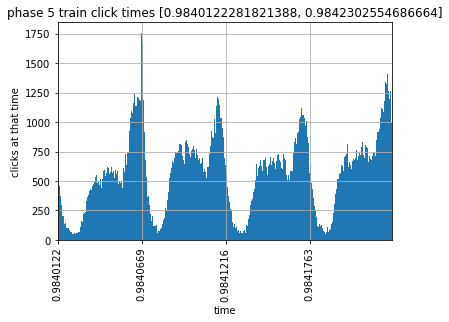

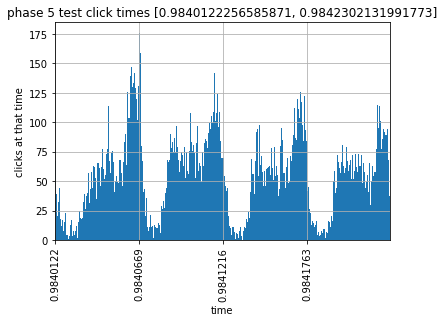

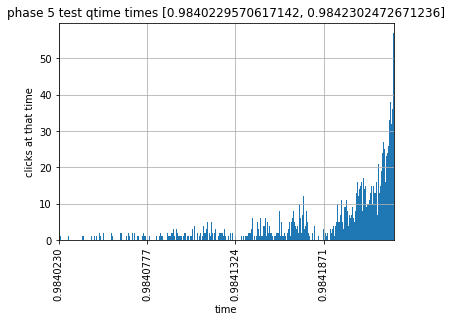

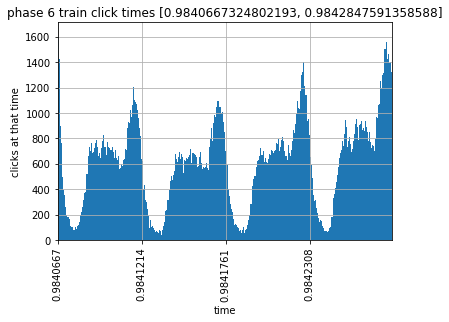

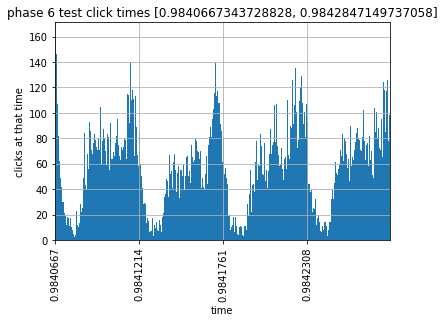

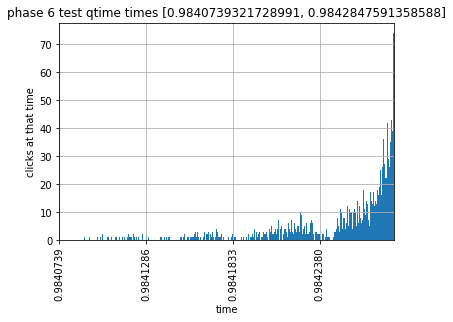

In [12]:
import matplotlib.pyplot as plt

def plot_times(domain="international", traintest="train", phase="0", filetype="click"):
    train_df = get_raw_dataset(domain, traintest, phase, filetype)
    train_user_times = {}
    for user_id, x in train_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])

    times = list(flatten(train_user_times.values()))
    min_time, max_time = min(times), max(times)
    plt.title(f"phase {phase} {traintest} {filetype} times [{min_time}, {max_time}]")

    plt.hist(times, bins=500)

    plt.xticks(np.arange(min_time, max_time, 0.0000547), rotation='vertical')
    plt.xlim(min_time, max_time)
    plt.xlabel("time")
    plt.ylabel("clicks at that time")
    plt.grid(True)

    plt.show()

plot_times(traintest="train", phase="0")
    
for phase in [str(i) for i in range(7)]:
    plot_times(traintest="train", phase=phase)
    plot_times(traintest="test", phase=phase)
    plot_times(traintest="test", filetype="qtime", phase=phase)


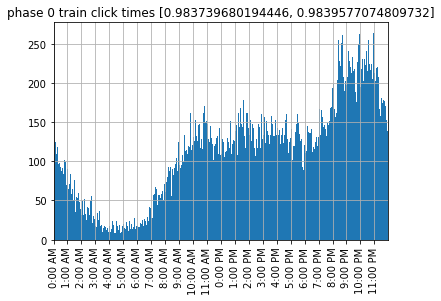

In [13]:
import matplotlib.pyplot as plt

def plot_times_over_first_day(domain="international", traintest="train", phase="0", filetype="click"):
    train_df = get_raw_dataset(domain, traintest, phase, filetype)
    train_user_times = {}
    for user_id, x in train_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])

    times = list(flatten(train_user_times.values()))
    min_time, max_time = min(times), max(times)
    plt.title(f"phase {phase} {traintest} {filetype} times [{min_time}, {max_time}]")

    plt.hist([time for time in times if time < min_time+0.0000547], bins=500)

    hours = [f"{i}:00 {am_pm}" for (am_pm, i) in product(("AM", "PM"), list(range(12)))]
    plt.xticks(np.arange(min_time, min_time+0.0000547, 0.0000547/24), hours, rotation='vertical')
    plt.xlim(min_time, min_time+0.0000547)
    plt.grid(True)

    plt.show()

plot_times_over_first_day(traintest="train", phase="0")

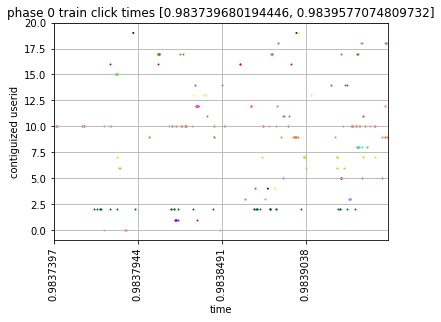

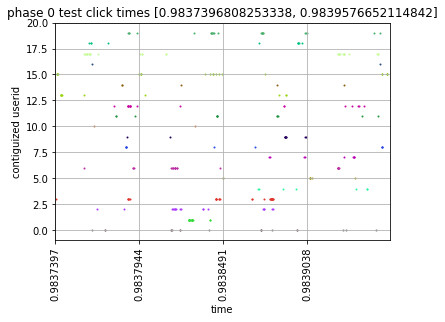

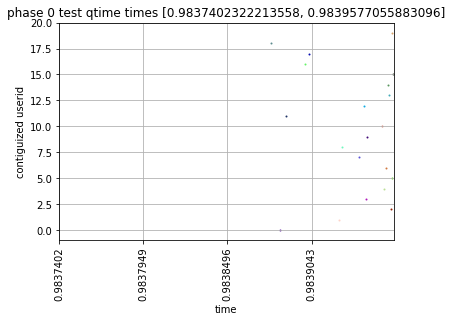

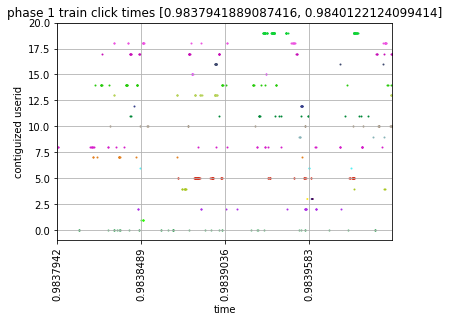

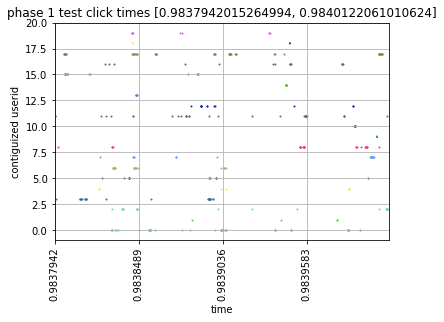

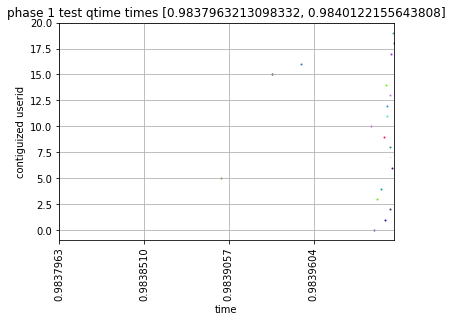

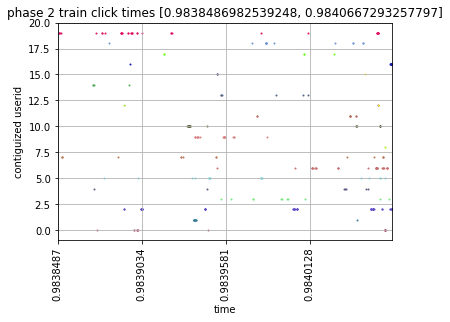

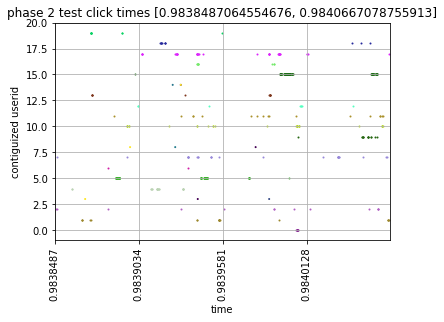

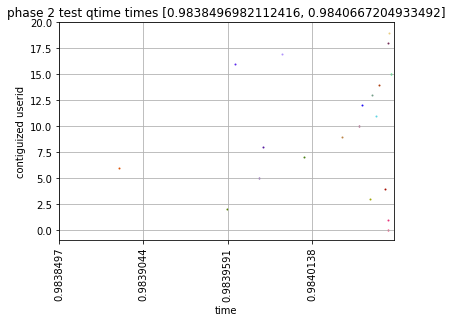

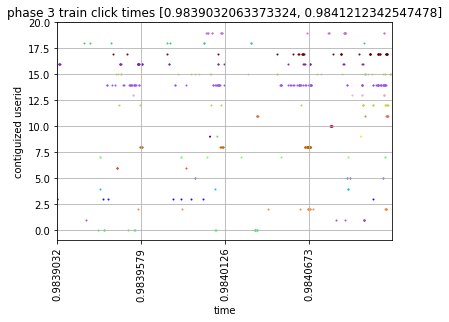

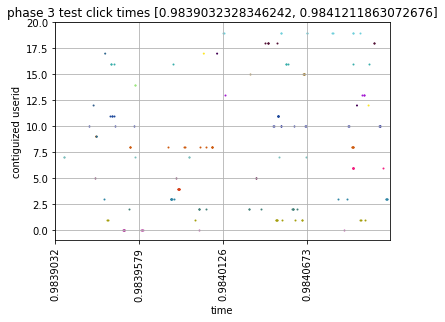

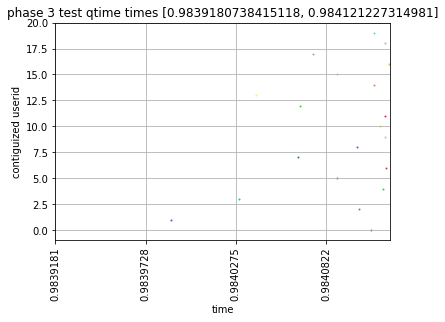

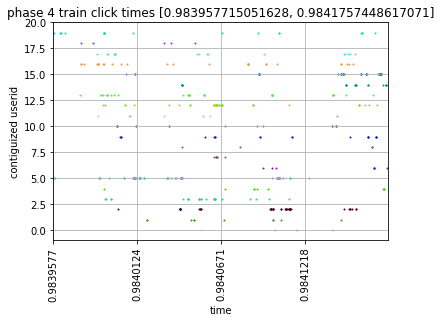

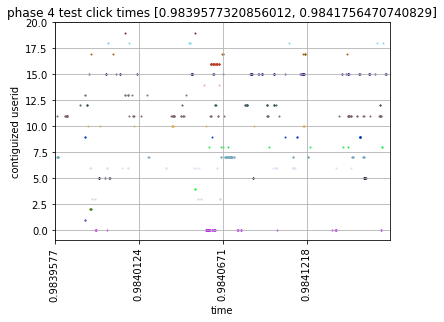

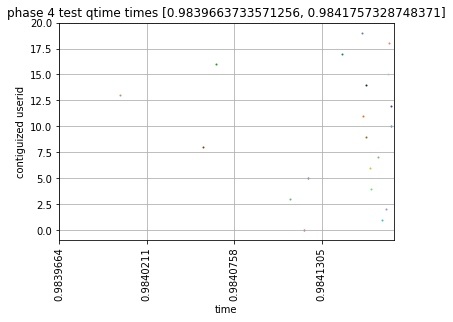

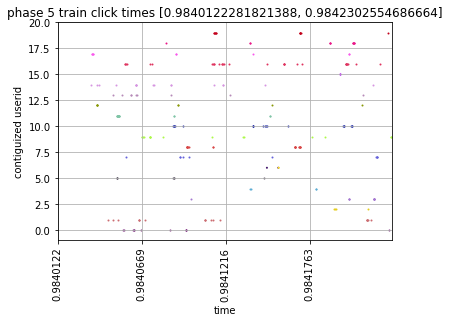

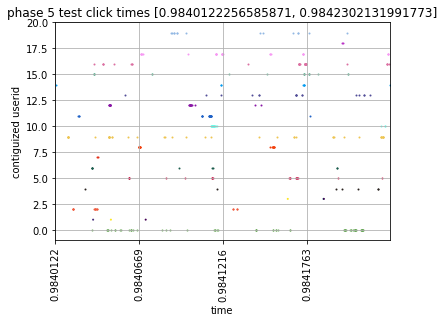

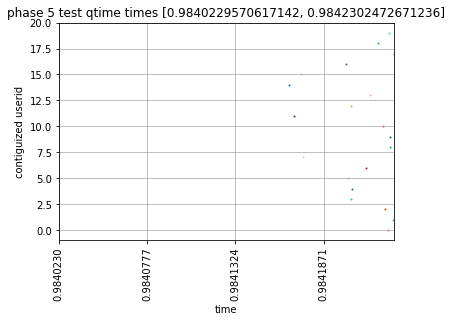

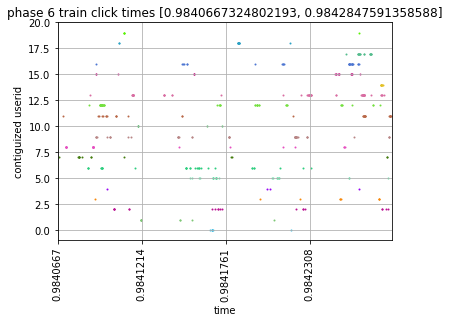

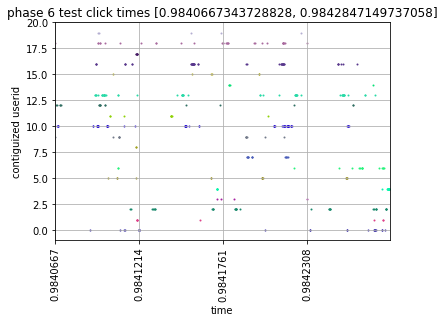

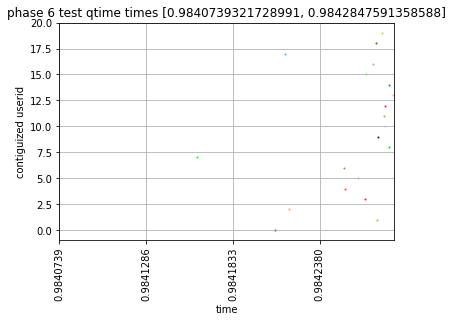

In [31]:
def scatter_plot_times(domain="international", traintest="train", phase="0", filetype="click"):
    train_df = get_raw_dataset(domain, traintest, phase, filetype)
    train_user_times = {}
    for user_id, x in train_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])

    times = list(flatten(train_user_times.values()))
    min_time, max_time = min(times), max(times)
    plt.title(f"phase {phase} {traintest} {filetype} times [{min_time}, {max_time}]")

    user_ids = list(train_user_times.keys())
    random.shuffle(user_ids)
    for i, user_id in enumerate(user_ids[:20]):
        plt.scatter(train_user_times[user_id], [i]*len(train_user_times[user_id]), c=np.random.uniform(0, 1, 3), s=1)

#     plt.hist(times, bins=500)
    
#     ex = train_user_times[1]
#     plt.scatter(ex, [10]*len(ex), c=[1, 0, 1])
    
    plt.xticks(np.arange(min_time, max_time, 0.0000547), rotation='vertical')
    plt.xlim(min_time, max_time)
    plt.grid(True)
    plt.xlabel("time")
    plt.ylabel("contiguized userid")

    plt.show()

for phase in [str(i) for i in range(7)]:
    scatter_plot_times(traintest="train", phase=phase)
    scatter_plot_times(traintest="test", phase=phase)
    scatter_plot_times(traintest="test", filetype="qtime", phase=phase)

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

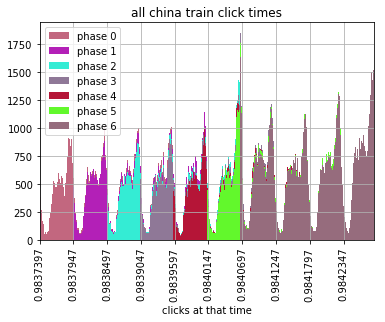

In [15]:
def plot_all_phases(domain="international", traintest="train", filetype="click"):
    min_time, max_time = 1, 0
    histograms = []
    for phase in tqdm([str(i) for i in range(7)]):
        train_df = get_raw_dataset(domain, traintest, phase, filetype)
        train_user_times = {}
        for user_id, x in train_df.groupby("user_id"):
            x = x.sort_values(by="time")
            train_user_times[user_id] = np.array(x["time"])

        times = list(flatten(train_user_times.values()))
        min_time = min(min_time, min(times))
        max_time = max(max_time, max(times))

        plt.hist(times, bins=500, color=np.random.uniform(0, 1, 3), label=f"phase {phase}")

    plt.title(f"all {domain} {traintest} {filetype} times")
    plt.xticks(np.arange(min_time, max_time, 0.000055), rotation='vertical')
    plt.xlim(min_time, max_time)
    plt.xlabel("time")
    plt.xlabel("clicks at that time")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_all_phases(domain="china", traintest="train", filetype="click")    
    

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/home/lucastong/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


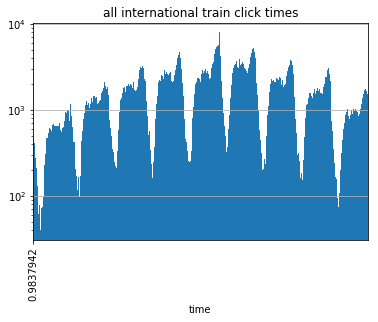

In [16]:
def plot_all_clicks_diff(domain="international", traintest="train", filetype="click"):
    min_time, max_time = 1, 0
    histograms = []
    full_df = get_raw_dataset(domain, traintest, "0", filetype).loc[0]

    for phase in tqdm([str(i) for i in range(1, 7)]):
        train_df = get_raw_dataset(domain, traintest, phase, filetype)
        full_df = full_df.append(train_df)

    train_user_times = {}
    for user_id, x in full_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])

    times = list(flatten(train_user_times.values()))
    min_raw_time = min(times)
    max_raw_time = max(times)

    plt.hist(times, bins=1000, log=True)
    plt.title(f"all {domain} {traintest} {filetype} times")
    plt.xticks(np.arange(min_raw_time, max_raw_time, 1), rotation='vertical')
    plt.xlim(min_raw_time, max_raw_time)
    plt.xlabel("frequency")
    plt.xlabel("time")
    plt.grid(True)
    plt.show()

plot_all_clicks_diff(domain="international", traintest="train", filetype="click")
    

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/home/lucastong/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))

HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))

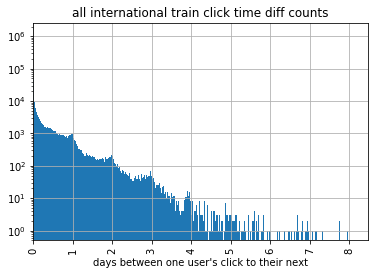

In [17]:
def plot_all_clicks_diff(domain="international", traintest="train", filetype="click"):
    min_time, max_time = 1, 0
    histograms = []
    full_df = get_raw_dataset(domain, traintest, "0", filetype).loc[0]

    for phase in tqdm([str(i) for i in range(1, 7)]):
        train_df = get_raw_dataset(domain, traintest, phase, filetype)
        full_df = full_df.append(train_df)
            
    train_user_times = {}
    for user_id, x in full_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])
    
    times = list(flatten(train_user_times.values()))
    min_raw_time = min(times)
    max_raw_time = max(times)
    
    for user_id, x in tqdm(train_user_times.items()):
        train_user_times[user_id] = (x-min_raw_time)/0.0000547
        
    raw_counts = list(flatten(train_user_times.values()))
    
    for user_id, x in tqdm(train_user_times.items()):
        train_user_times[user_id] = x[1:]-x[:-1]
        
    diff_counts = list(flatten(train_user_times.values()))
    min_diff_time = min(diff_counts)
    max_diff_time = max(diff_counts)

    plt.hist(diff_counts, bins=1000, log=True)
    plt.title(f"all {domain} {traintest} {filetype} time diff counts")
    plt.xticks(np.arange(min_diff_time, max_diff_time, 1), rotation='vertical')
    plt.xlim(min_diff_time, max_diff_time)
    plt.xlabel("frequency")
    plt.xlabel("days between one user's click to their next")
    plt.grid(True)
    plt.show()

plot_all_clicks_diff(domain="international", traintest="train", filetype="click")
    

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/home/lucastong/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))

HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))


1585261 diff counts total
1545469 diff counts with diff < 1


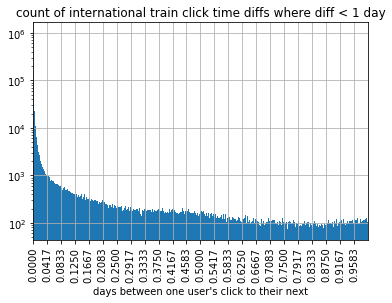

In [18]:
def plot_all_clicks_diff(domain="international", traintest="train", filetype="click"):
    min_time, max_time = 1, 0
    histograms = []
    full_df = get_raw_dataset(domain, traintest, "0", filetype).loc[0]
#     print(full_df)
    for phase in tqdm([str(i) for i in range(1, 7)]):
        train_df = get_raw_dataset(domain, traintest, phase, filetype)
        full_df = full_df.append(train_df)
            
    train_user_times = {}
    for user_id, x in full_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])
    
    times = list(flatten(train_user_times.values()))
    min_raw_time = min(times)
    max_raw_time = max(times)
    
    for user_id, x in tqdm(train_user_times.items()):
        train_user_times[user_id] = (x-min_raw_time)/0.0000547
        
    raw_times = list(flatten(train_user_times.values()))
    
    for user_id, x in tqdm(train_user_times.items()):
        train_user_times[user_id] = x[1:]-x[:-1]
        
    diff_counts = list(flatten(train_user_times.values()))
    print(f"{len(diff_counts)} diff counts total")
    diff_counts = [i for i in diff_counts if i < 1]
    print(f"{len(diff_counts)} diff counts with diff < 1")
    min_diff_time = min(diff_counts)
    max_diff_time = max(diff_counts)
    
    plt.clf()
    plt.cla()
    plt.hist(diff_counts, bins=1000, log=True)
    plt.title(f"count of {domain} {traintest} {filetype} time diffs where diff < 1 day")
    plt.xticks(np.arange(min_diff_time, max_diff_time, 1/24), rotation='vertical')
    plt.xlim(min_diff_time, max_diff_time)
    plt.xlabel("count")
    plt.xlabel("days between one user's click to their next")
    plt.grid(True)
    plt.show()

plot_all_clicks_diff(domain="international", traintest="train", filetype="click")

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/home/lucastong/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))


69384 sessions total
7991 sessions w len 1


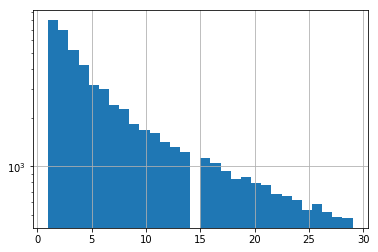

In [16]:
def plot_all_clicks_diff(domain="international", traintest="train", filetype="click"):
    min_time, max_time = 1, 0
    histograms = []
    full_df = get_raw_dataset(domain, traintest, "0", filetype).loc[0]
    for phase in tqdm([str(i) for i in range(1, 7)]):
        train_df = get_raw_dataset(domain, traintest, phase, filetype)
        full_df = full_df.append(train_df)

    train_user_times = {}
    train_user_items = {}
    for user_id, x in full_df.groupby("user_id"):
        x = x.sort_values(by="time")
        train_user_times[user_id] = np.array(x["time"])
        train_user_items[user_id] = np.array(x["item_id"])

    times = list(flatten(train_user_times.values()))
    min_raw_time = min(times)
    max_raw_time = max(times)

    for user_id, x in tqdm(train_user_times.items()):
        train_user_times[user_id] = (x-min_raw_time)/0.0000547

    sessions = {}

    for user_id, times in train_user_times.items():
        sessions[user_id] = []
        items = train_user_items[user_id]
        cur_session = []
        prev_time = None
        for i in range(len(times)):
            time, item = times[i], items[i]

            if prev_time != None and time - prev_time > 1:
                sessions[user_id].append(cur_session)
                cur_session = []

            prev_time = time
            cur_session.append((time, item))
        sessions[user_id].append(cur_session)

    session_lengths = list(flatten([[len(sess) for sess in u_sess] for u_sess in sessions.values()]))
    print(f"{len(session_lengths)} sessions total")
    print(f"{len([i for i in session_lengths if i == 1])} sessions w len 1")

    plt.hist([i for i in session_lengths if i < 30], bins=30, log=True)
    plt.grid(True)
    plt.show()

plot_all_clicks_diff(domain="international", traintest="train", filetype="click")

In [20]:
train_df = get_raw_dataset("international", "train", "6", "click")
test_df = get_raw_dataset("international", "test", "6", "click")
qtime_test_df = get_raw_dataset("international", "test", "6", "qtime")

test_user_times = {}
test_user_items = {}

qtest_user_times = {}

train_user_times = {}
train_user_times = {}

for user_id, x in test_df.groupby("user_id"):
    x = x.sort_values(by="time")
    test_user_times[user_id] = np.array(x["time"])
    test_user_items[user_id] = np.array(x["item_id"])

for user_id, x in qtime_test_df.groupby("user_id"):
    x = x.sort_values(by="time")
    qtest_user_times[user_id] = np.array(x["time"])

for user_id, x in train_df.groupby("user_id"):
    x = x.sort_values(by="time")
    train_user_times[user_id] = np.array(x["time"])
    train_user_items = np.array(x["item_id"])

# all users in test_qtimes appear in test_clicks and vice versa. all qtime clicks appear at the end of sessions. 

for user_id, times in qtest_user_times.items():
    if not all(test_user_times[user_id] < times[0]):
        print(user_id)

for user_id, times in test_user_times.items():
    if user_id not in qtest_user_times:
        print(user_id)

# some users in qtest_user_times arent in train_user times and vise versa. we can't train each period independently

for user_id, times in qtest_user_times.items():
    if user_id not in train_user_times:
        print(user_id)

for user_id, times in train_user_times.items():
    if user_id not in qtest_user_times:
        print(user_id)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

/home/lucastong/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))


(869, 32578.0, array([0.57471927, 0.58251598, 0.58303499, 0.5862644 , 0.58739469,
       0.59880142, 0.60143108, 0.62569778, 0.62808523, 0.62884645,
       0.70540648, 1.39867962, 1.39991372, 1.40019052, 1.40153995,
       1.40282018, 1.40282018, 1.40479243, 1.49345121, 1.49345121,
       1.49403942, 1.49403942, 1.49505438, 1.51331207, 1.51331207,
       1.5149383 , 1.5149383 , 1.51625313, 1.51625313, 1.54261894,
       1.54261894, 1.81376234, 1.81376234, 1.96625959, 1.96625959,
       1.96629419, 1.96629419, 1.966571  , 1.966571  , 1.9667094 ,
       1.9667094 , 1.96675553, 1.96675553, 1.96690547, 1.96690547,
       1.97794313, 1.97794313, 1.97823147, 1.97823147, 1.97872741,
       1.97872741, 1.98001917, 2.42401662, 2.42401662, 2.57544125,
       2.57544125, 2.57544125, 3.52666334, 3.52666334, 3.52666334,
       3.52666334, 3.52734383, 3.52758603, 3.52773597, 3.52773597,
       3.52773597, 3.52773597, 3.53484067, 3.53484067, 3.53484067,
       3.53484067, 3.53627083, 3.53627083, 3.5

HBox(children=(IntProgress(value=0, max=29592), HTML(value='')))


8.70566369288997 sessions per user on average
7.0 median sessions per user


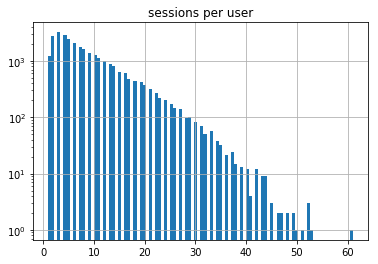

0.009674646512243526 session hours
0.000899620767886411 median session hours


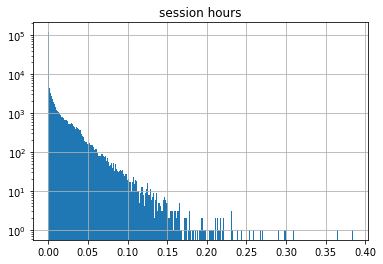

phase 1:
average train session clicks: 4.700956267754972
median train session clicks: 2.0
24993 total sessions
19274 sessions w/ length 1
74.82% of sessions will be pruned


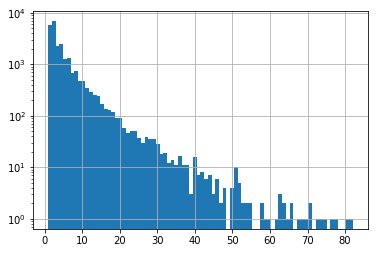

phase 2:
average train session clicks: 6.343567145849888
median train session clicks: 3.0
27686 total sessions
22873 sessions w/ length 1
77.27% of sessions will be pruned


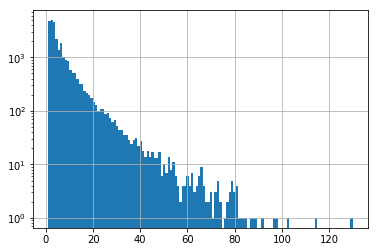

phase 4:
average train session clicks: 8.78560221504384
median train session clicks: 4.0
32505 total sessions
27697 sessions w/ length 1
80.64% of sessions will be pruned


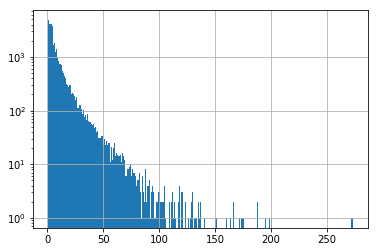

phase 5:
average train session clicks: 8.623191272891702
median train session clicks: 4.0
35384 total sessions
30335 sessions w/ length 1
82.22% of sessions will be pruned


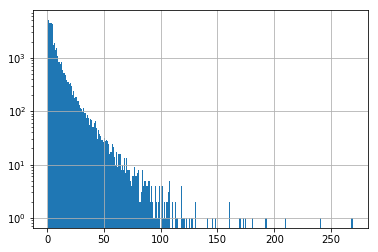

phase 6:
average train session clicks: 6.640047401165279
median train session clicks: 3.0
30379 total sessions
25513 sessions w/ length 1
79.29% of sessions will be pruned


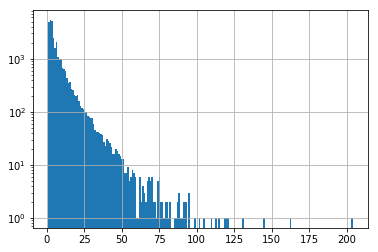

phase 7:
average train session clicks: 5.007227310574521
median train session clicks: 3.0
30025 total sessions
23494 sessions w/ length 1
79.04% of sessions will be pruned


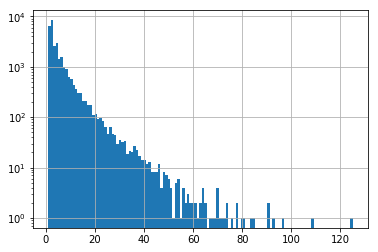

phase 8:
average train session clicks: 3.2120167815403056
median train session clicks: 2.0
26696 total sessions
15453 sessions w/ length 1
76.43% of sessions will be pruned


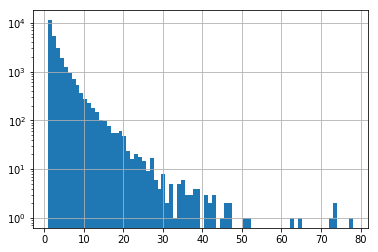

phase 0:
average train session clicks: 2.8803224370703724
median train session clicks: 2.0
20221 total sessions
11319 sessions w/ length 1
68.88% of sessions will be pruned


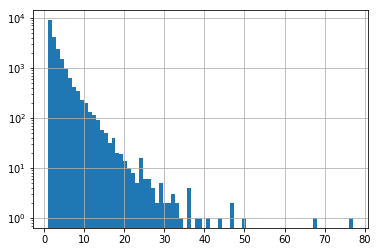

phase 3:
average train session clicks: 7.904201284940631
median train session clicks: 4.0
29729 total sessions
25023 sessions w/ length 1
78.83% of sessions will be pruned


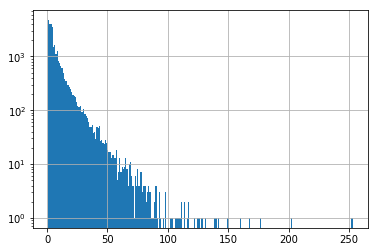

In [30]:
# characteristics of sessions after merging all periods then chunking by session start time

domain = "china"
traintest = "train"
filetype = "click"

min_time, max_time = 1, 0
histograms = []
full_df = get_raw_dataset(domain, traintest, "0", filetype).loc[0]
for phase in tqdm([str(i) for i in range(1, 7)]):
    train_df = get_raw_dataset(domain, traintest, phase, filetype)
    full_df = full_df.append(train_df)

train_user_times = {}
train_user_items = {}
for user_id, x in full_df.groupby("user_id"):
    x = x.sort_values(by="time")
    train_user_times[user_id] = np.array(x["time"])
    train_user_items[user_id] = np.array(x["item_id"])

times = list(flatten(train_user_times.values()))
min_raw_time = min(times)
max_raw_time = max(times)

for user_id, x in tqdm(train_user_times.items()):
    train_user_times[user_id] = (x-min_raw_time)/0.0000547

print(max((len(times), user_id, times) for user_id, times in train_user_times.items()))
    
sessions = {}
for user_id, times in tqdm(train_user_times.items()):
    sessions[user_id] = []
    items = train_user_items[user_id]
    cur_session = []
    prev_time = None
    for i in range(len(times)):
        time, item = times[i], items[i]

        if prev_time != None and time - prev_time > 1/24:
            sessions[user_id].append(cur_session)
            cur_session = []

        prev_time = time
        cur_session.append((time, item))
    sessions[user_id].append(cur_session)
    
len_sessions = [len(sesses) for sesses in sessions.values()]
print(f"{np.mean(len_sessions)} sessions per user on average")
print(f"{np.median(len_sessions)} median sessions per user")

plt.clf()
plt.title("sessions per user")
plt.hist(len_sessions, 100, log=True)
plt.grid(True)
plt.show()

len_sessions = [session[-1][0] - session[0][0] for session in flatten(sessions.values())]
print(f"{np.mean(len_sessions)} session hours")
print(f"{np.median(len_sessions)} median session hours")

plt.clf()
plt.title("session hours")
plt.hist(len_sessions, 1000, log=True)
plt.grid(True)
plt.show()

phases = defaultdict(lambda: [])
for user_id, user_sessions in sessions.items():
    for user_session in user_sessions:
        start_time = user_session[0][0]
        phases[int(start_time)].append((user_id, user_session))

for phase, sessions in phases.items():
    print(f"phase {phase}:")
    session_lengths = [len(sess[1]) for sess in sessions]
    plt.clf()

    plt.hist(session_lengths, bins=max(session_lengths)-min(session_lengths)+1, log=True)
    print(f"average train session clicks: {np.mean(session_lengths)}")
    print(f"median train session clicks: {np.median(session_lengths)}")

    num_sessions = len(session_lengths)
    num_sesses_w_len_1 = len([length for length in session_lengths if length > 1])
    print(f"{num_sessions} total sessions")
    print(f"{num_sesses_w_len_1} sessions w/ length 1")
    print(f"{(num_sessions-num_sesses_w_len_2)/num_sessions*100:.2f}% of sessions will be pruned")
    plt.grid(True)
    plt.show()